### **Importing Libraries**

In [13]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import wandb
from skimage.feature import hog
from skimage import exposure
import seaborn as sns
import copy
from IPython.display import Image
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torchvision.models as models
import tqdm
from torchvision import transforms
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### **Loading Dataset**

In [12]:

train_data = pd.read_csv('./Dataset/train_data.csv')
val_data = pd.read_csv('./Dataset/val_data.csv')
test_data = pd.read_csv('./Dataset/test_data.csv')

train_data = train_data.drop(columns=['Address'])
val_data = val_data.drop(columns=['Address'])
test_data = test_data.drop(columns=['Address'])

print(train_data.shape, val_data.shape, test_data.shape)
# print(train_data.head())

(9059, 13) (2265, 13) (2831, 13)


### **Processing Missing Values and Scaling**

In [3]:
def analyze_and_impute(data, dataset_name):
    zero_counts = (data == 0).sum()
    total_rows = len(data)

    missing_summary = pd.DataFrame({
        'Zero Count': zero_counts.drop('FLAG', errors='ignore')
    }).sort_values('Zero Count', ascending=False)

    print(f"\nMissing Values Summary for {dataset_name} (considering zeros as missing):")
    print(f"Total rows: {total_rows}")
    print("\nZero counts and percentages by column:")
    print(missing_summary)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=missing_summary.index, y='Zero Count', data=missing_summary)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Percentage of Zero Values by Column - {dataset_name}')
    plt.tight_layout()
    plt.show()

    columns_to_impute = data.columns.difference(['FLAG'])

    data = data.loc[~(data[columns_to_impute].sum(axis=1) == 0)].copy()
    
    print(f"Rows with all zeros removed in {dataset_name}.")
    print(f"Updated dataset shape: {data.shape}")

    for column in columns_to_impute:
        median_value = data.loc[data[column] != 0, column].median()
        data.loc[:, column] = data[column].replace(0, median_value)

    print(f"Imputation completed for {dataset_name}. Zeros replaced with column medians.")
    
    scaler = MinMaxScaler()
    data[columns_to_impute] = scaler.fit_transform(data[columns_to_impute])

    print("Feature scaling completed for columns with large ranges.")

    return data


Missing Values Summary for Train (considering zeros as missing):
Total rows: 9059

Zero counts and percentages by column:
                                                    Zero Count
min val sent                                              3919
Avg min between sent tnx                                  3154
Avg min between received tnx                              2991
min value received                                        2427
avg val sent                                              2279
avg val received                                          1363
max value received                                        1361
total ether received                                      1361
total ether balance                                       1349
Time Diff between first and last (Mins)                   1300
Unique Received From Addresses                            1254
total transactions (including tnx to create con...        1239


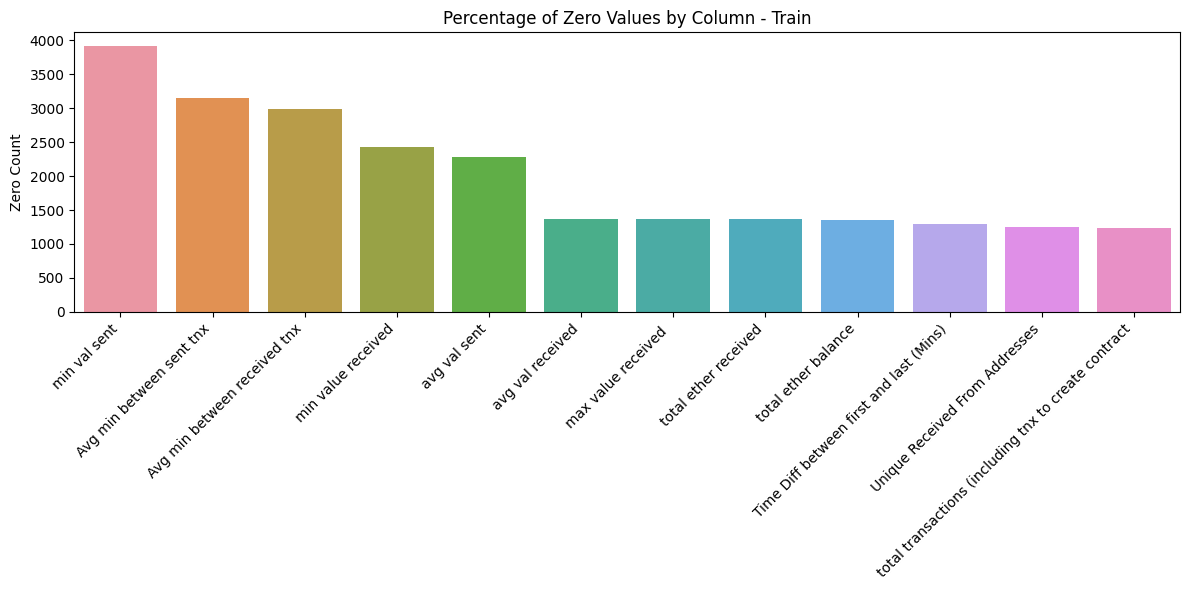

Rows with all zeros removed in Train.
Updated dataset shape: (7820, 13)
Imputation completed for Train. Zeros replaced with column medians.
Feature scaling completed for columns with large ranges.


In [4]:
train_data = analyze_and_impute(train_data, "Train")


Missing Values Summary for Validation (considering zeros as missing):
Total rows: 2265

Zero counts and percentages by column:
                                                    Zero Count
min val sent                                               939
Avg min between sent tnx                                   760
Avg min between received tnx                               743
min value received                                         595
avg val sent                                               529
max value received                                         317
avg val received                                           317
total ether received                                       317
total ether balance                                        314
Time Diff between first and last (Mins)                    302
Unique Received From Addresses                             292
total transactions (including tnx to create con...         290


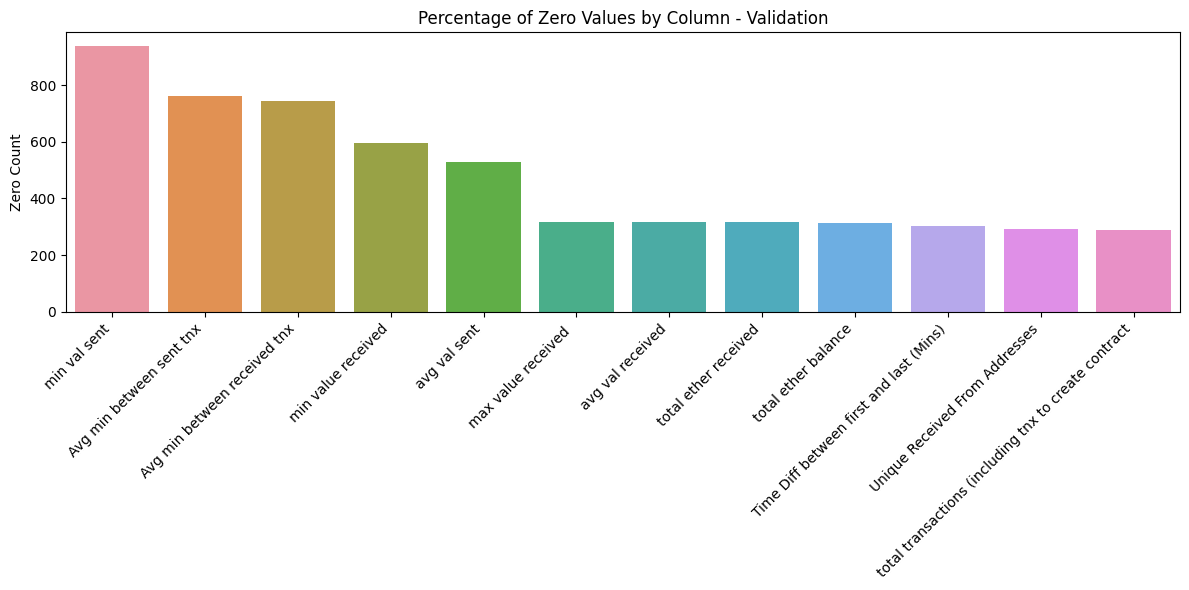

Rows with all zeros removed in Validation.
Updated dataset shape: (1975, 13)
Imputation completed for Validation. Zeros replaced with column medians.
Feature scaling completed for columns with large ranges.


In [5]:
val_data = analyze_and_impute(val_data, "Validation")


Missing Values Summary for Test (considering zeros as missing):
Total rows: 2831

Zero counts and percentages by column:
                                                    Zero Count
min val sent                                              1235
Avg min between sent tnx                                   975
Avg min between received tnx                               931
min value received                                         788
avg val sent                                               698
max value received                                         410
avg val received                                           410
total ether received                                       410
total ether balance                                        407
Time Diff between first and last (Mins)                    400
Unique Received From Addresses                             378
total transactions (including tnx to create con...         373


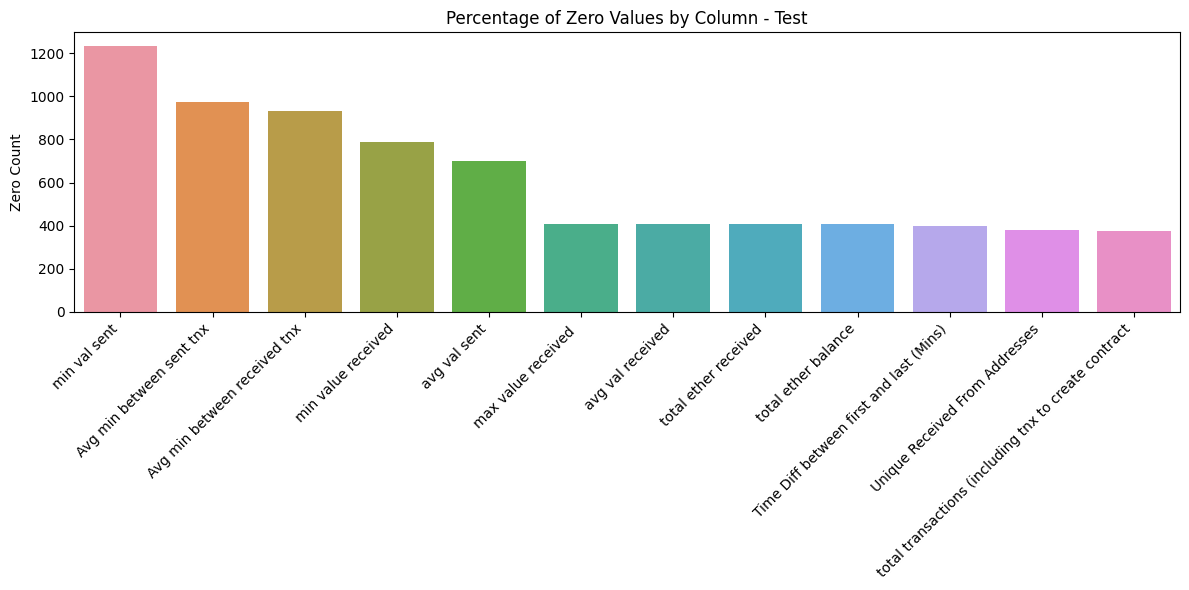

Rows with all zeros removed in Test.
Updated dataset shape: (2458, 13)
Imputation completed for Test. Zeros replaced with column medians.
Feature scaling completed for columns with large ranges.


In [6]:
test_data = analyze_and_impute(test_data, "Test")

### **Visualization**

In [10]:
def plot_correlation_matrix(data, dataset_name):

    correlation_matrix = data.corr()

    plt.figure(figsize=(8, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    plt.title(f"Correlation Matrix of Features (Including FLAG) - {dataset_name}")
    plt.show()


def plot_violin_plots(data, dataset_name):

    columns_to_plot = data.columns.difference(['FLAG'])

    plt.figure(figsize=(10, len(columns_to_plot) * 3))

    for idx, column in enumerate(columns_to_plot, 1):
        plt.subplot(len(columns_to_plot), 1, idx)
        sns.violinplot(x='FLAG', y=column, data=data, palette='coolwarm', scale='width')
        plt.title(f'Violin Plot of {column} by FLAG - {dataset_name}')
        plt.tight_layout()

    plt.show()

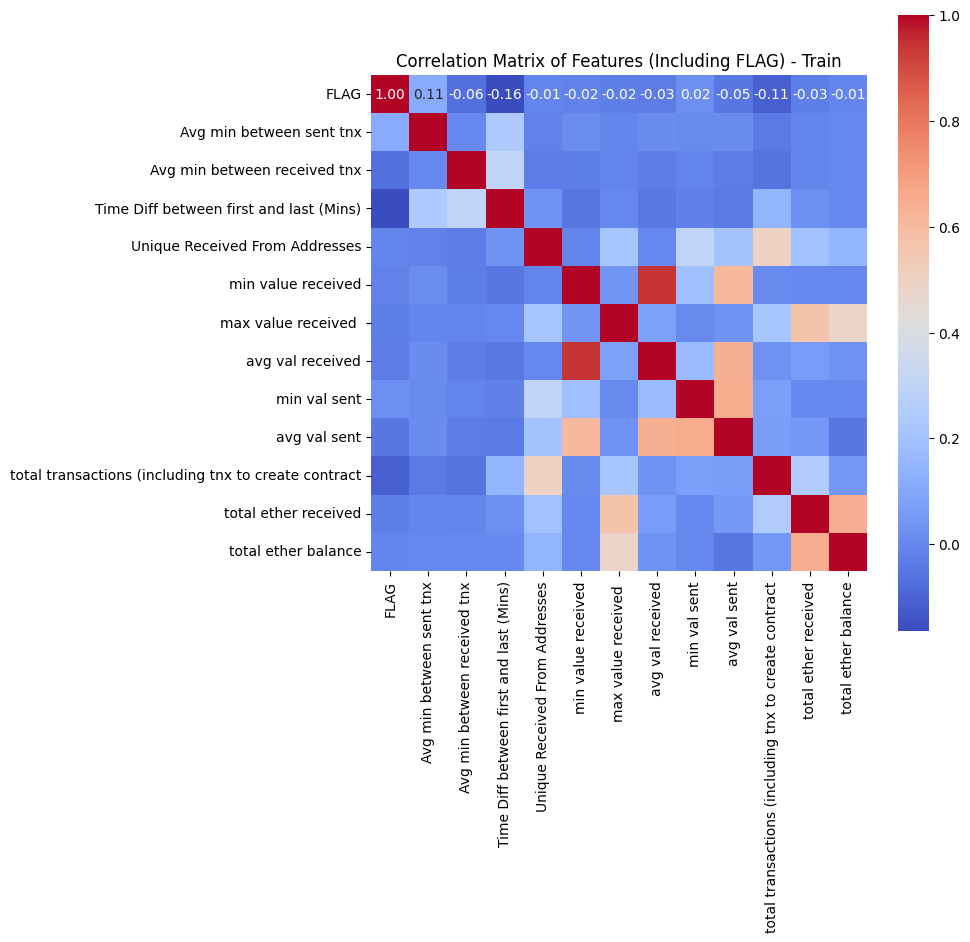

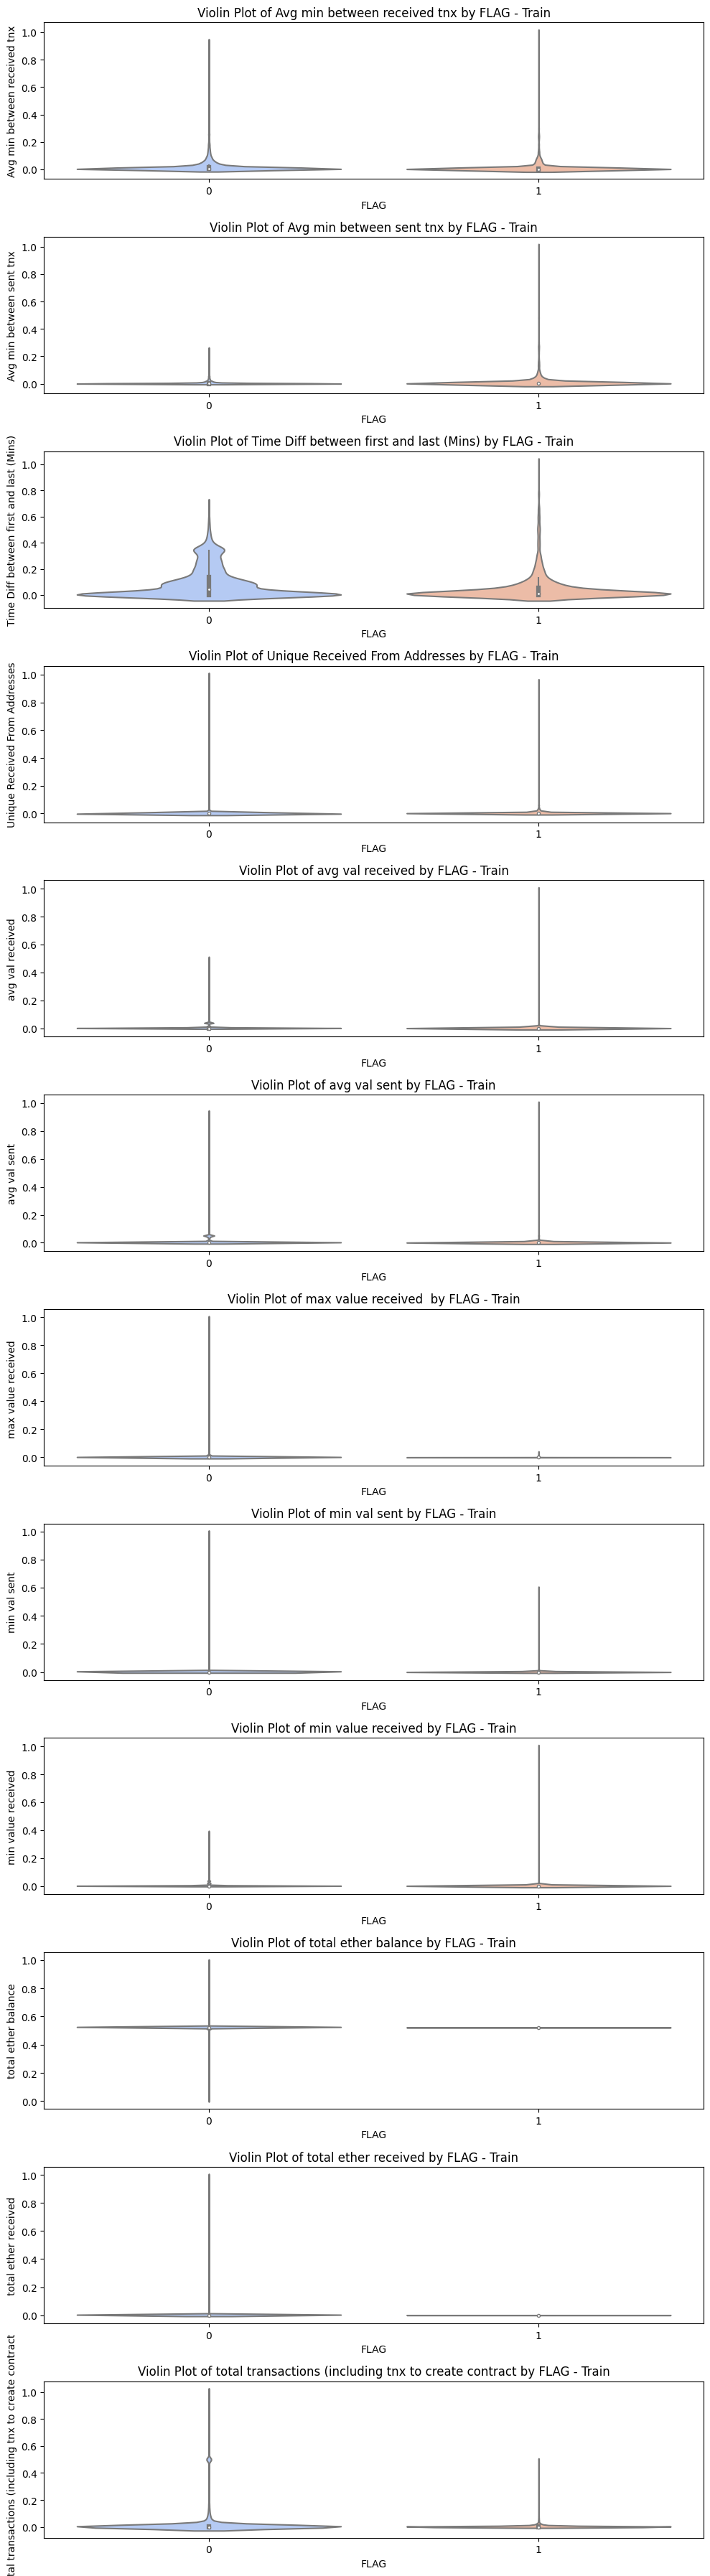

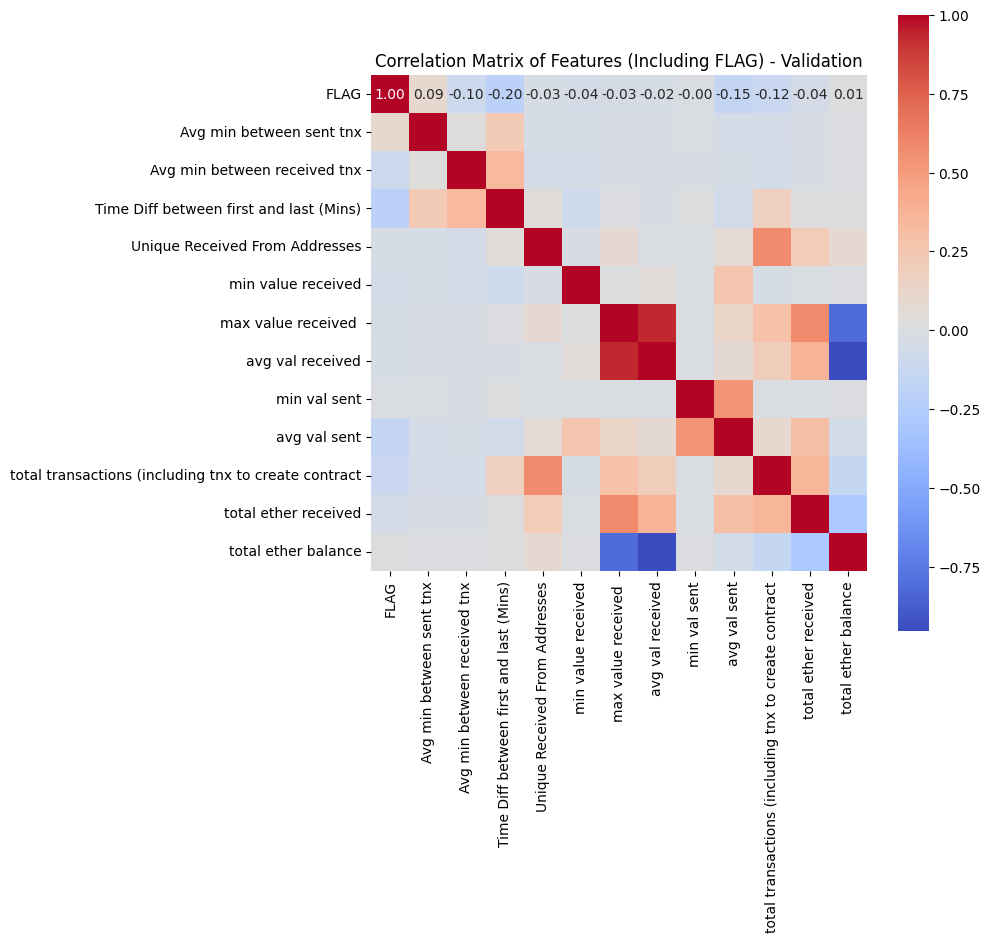

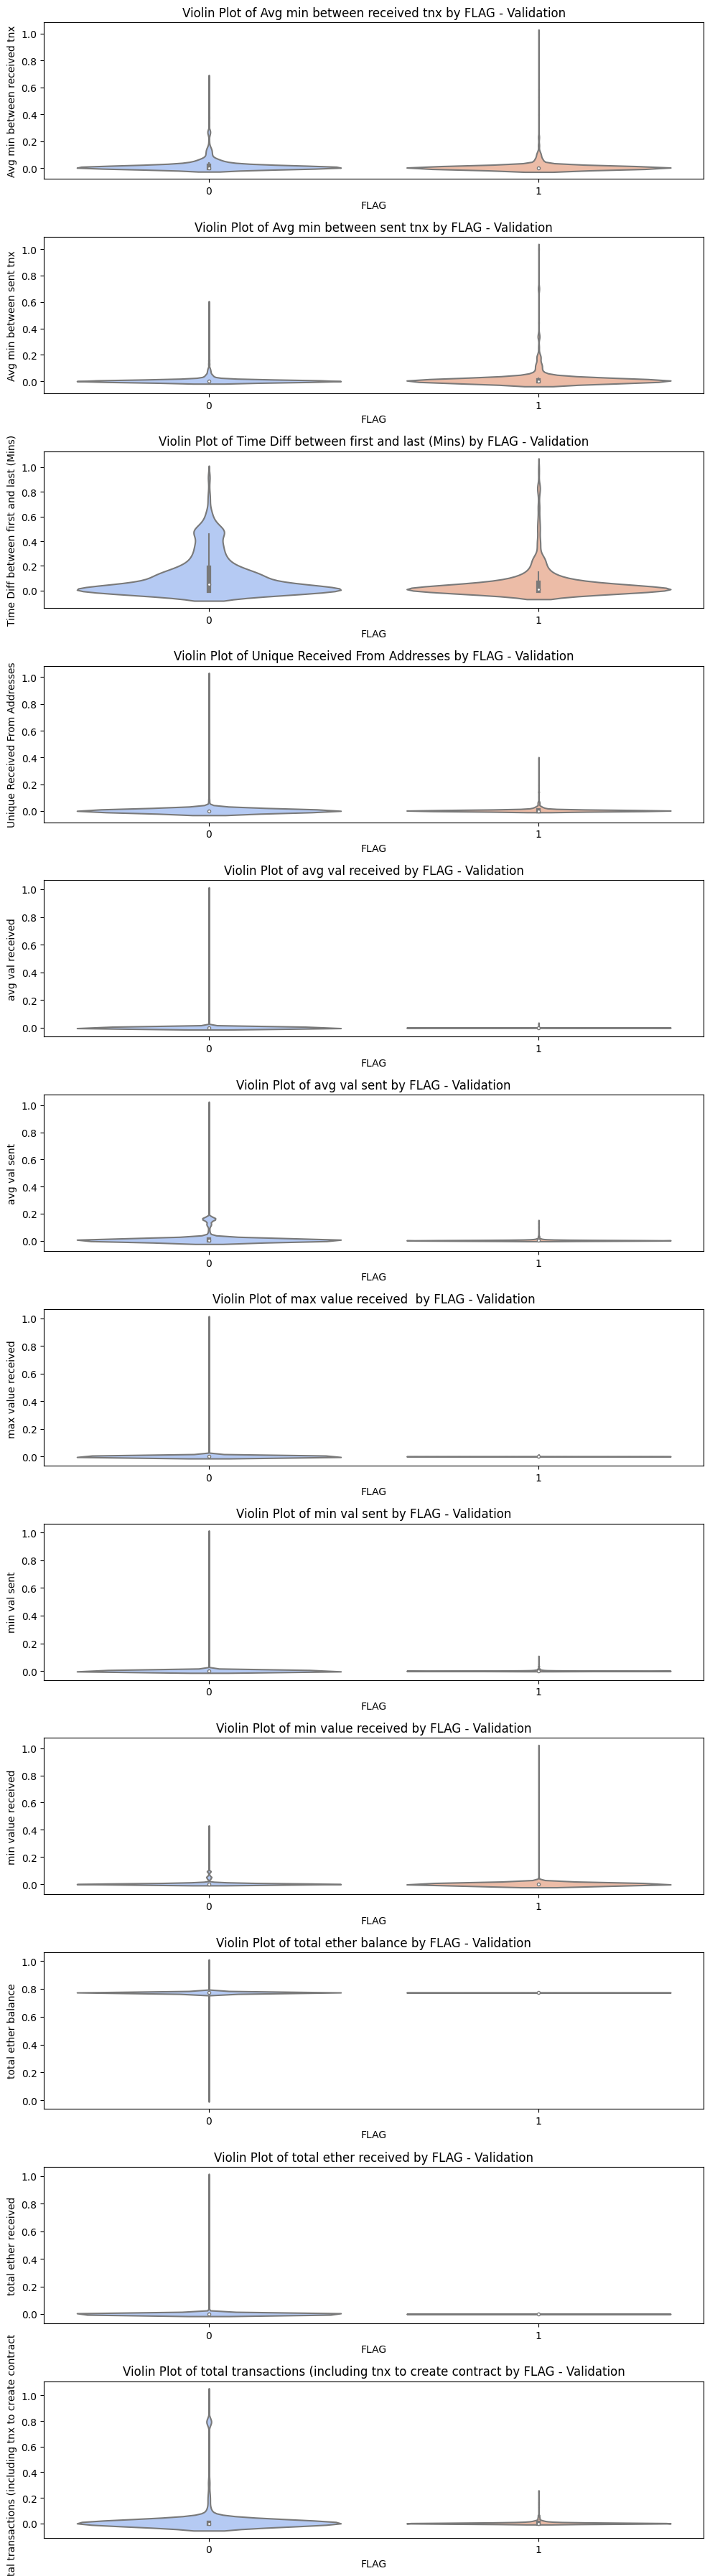

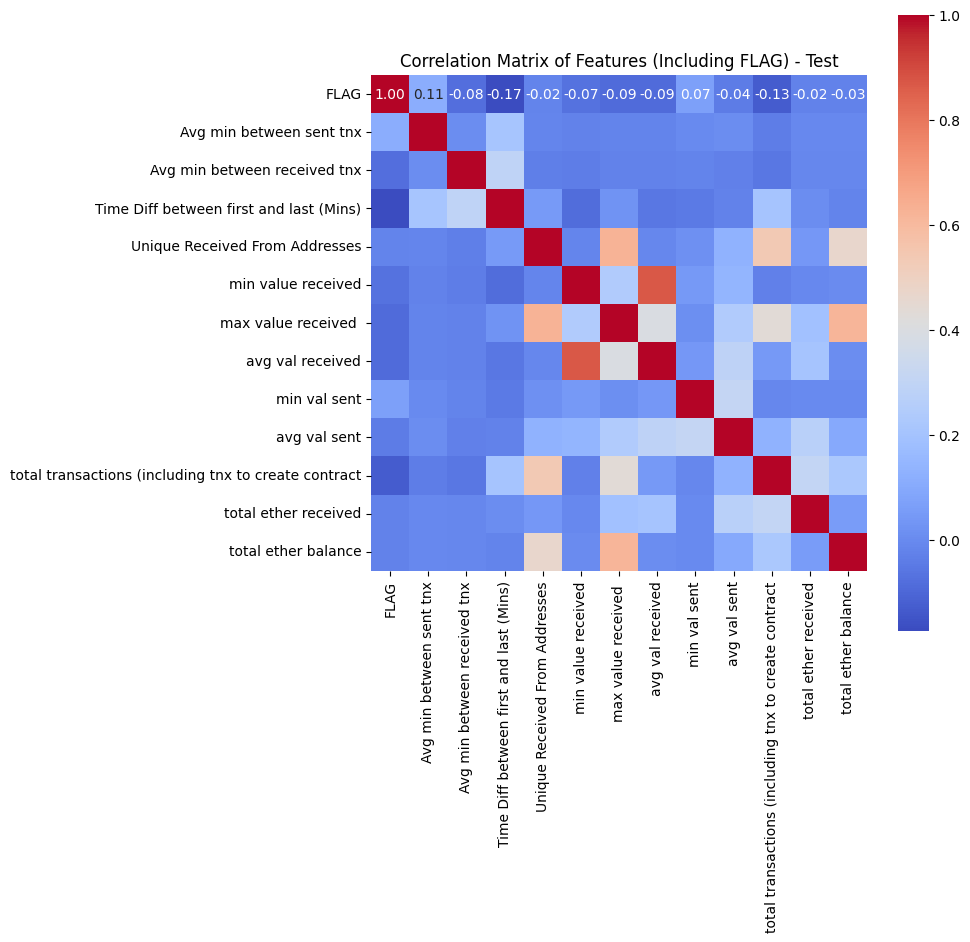

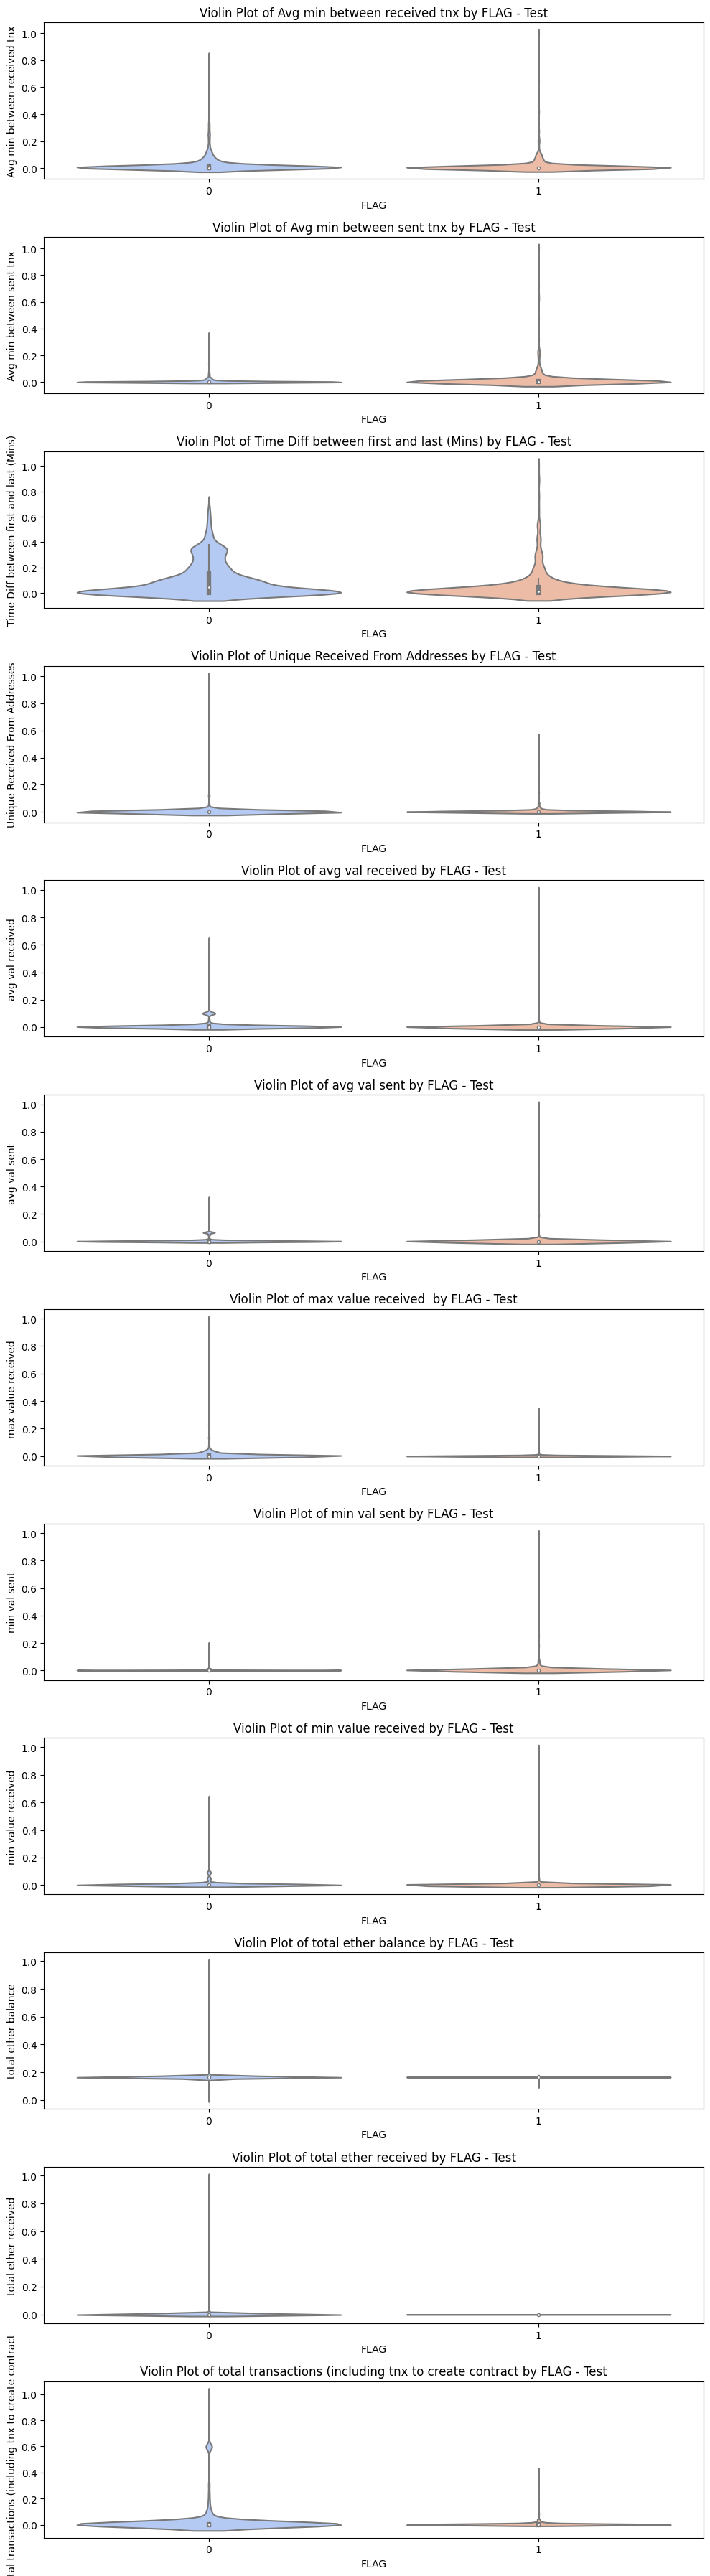

In [11]:
for dataset, name in zip([train_data, val_data, test_data], ["Train", "Validation", "Test"]):
    plot_correlation_matrix(dataset, name)
    plot_violin_plots(dataset, name)